# 1.1 Introduction to the Use Case for Project B

**Project Name:** UC00200_Educational_Equity_Study  
**Authored by:** Areeb Ashraf Bana   
**Duration:** 90 mins    
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Visualisation


### **Objective:**

The project’s objective is to analyse and visualise how public transport infrastructure in Melbourne aligns with educational and public facilities like schools and libraries.  

The study focuses on:   
- Mapping their geographical distribution across Melbourne  
- Identifying how accessible educational facilities are via public transport  
- Offering data-driven insights to improve urban planning and transport efficiency


### **Scenario:**

With the growing population and urban expansion in Melbourne, it is crucial to ensure that educational facilities are well-connected to public transport.  

By analyzing transport and facility data, city planners can:  
- Identify areas with good accessibility versus underserved regions  
- Support policy-making and city planning for sustainable urban growth  
- Enhance commuting options for students and residents


### **What You Will Learn from This Use Case:**

1. Fetch and clean real-world public transport and educational facility datasets using APIs  
2. Visualise tram tracks, train stations, and educational landmarks on interactive maps  
3. Combine multiple datasets into one data-driven view of Melbourne’s transport accessibility 
4. Analyse and highlight patterns, gaps, and recommendations for improved accessibility  

### **Initial Setup and Data Loading**

In this section, we import the core Python libraries for data analysis:

- **Pandas, NumPy** → data manipulation  
- **GeoPandas, Shapely, SciPy (KDTree)** → geospatial processing  
- **scikit-learn** → modelling and evaluation  
- **Matplotlib, Seaborn, Folium** → visualisation  

All required datasets are loaded directly from GitHub, making the notebook portable across devices:

- **School locations dataset** (`dv309_schoollocations2021.csv`)  
- **Public transport stops dataset** (`public_transport_stops.geojson`)  
- **School–stop merged dataset** (`school_stop_all_records.csv`)  

This ensures the analysis can run anywhere with internet access, without needing local files.



In [46]:
# === Core Libraries ===
import pandas as pd
import numpy as np
import requests
from pathlib import Path

# === Geospatial Analysis ===
import geopandas as gpd
from shapely.geometry import Point, box
from scipy.spatial import cKDTree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

# === Settings ===
plt.style.use("default")
sns.set_theme()


In [47]:
# --- School locations dataset ---
schools_url = "https://raw.githubusercontent.com/AreebAshraf96/Education-Equity-Datasets/main/dv309_schoollocations2021.csv"
schools_df = pd.read_csv(schools_url, encoding="ISO-8859-1")
print("Schools dataset loaded:", schools_df.shape)

# --- Public transport stops (GeoJSON) ---
transport_url = "https://raw.githubusercontent.com/AreebAshraf96/Education-Equity-Datasets/main/public_transport_stops.geojson"
transport_stops = gpd.read_file(transport_url)
print("Transport stops dataset loaded:", transport_stops.shape)

# --- School + stop merged dataset ---
school_stop_url = "https://raw.githubusercontent.com/AreebAshraf96/Education-Equity-Datasets/main/school_stop_all_records.csv"
school_stop_df = pd.read_csv(school_stop_url)
print("School-stop merged dataset loaded:", school_stop_df.shape)

# --- Preview ---
print("\nSample school records:\n", schools_df.head())
print("\nSample transport stops:\n", transport_stops.head())
print("\nSample merged records:\n", school_stop_df.head())


Schools dataset loaded: (2291, 21)
Transport stops dataset loaded: (29202, 4)
School-stop merged dataset loaded: (1369, 5)

Sample school records:
   Education_Sector  Entity_Type  SCHOOL_NO  \
0       Government            1          1   
1       Government            1          3   
2       Government            1          4   
3       Government            1          8   
4       Government            1         12   

                              School_Name School_Type School_Status  \
0                 Alberton Primary School     Primary             O   
1  Allansford and District Primary School     Primary             O   
2                    Avoca Primary School     Primary             O   
3                   Avenel Primary School     Primary             O   
4               Warrandyte Primary School     Primary             O   

       Address_Line_1 Address_Line_2 Address_Town Address_State  ...  \
0   21 Thomson Street            NaN     Alberton           VIC  ...   
1   

### **Cleaning, Filtering, and Linking Schools to Transport Stops** 

This section prepares the school and transport datasets for analysis. First, it selects only the most relevant school attributes (such as sector, type, location, and status) and converts the latitude/longitude coordinates into **geometric points**. Both schools and transport stops are then filtered so that only those located within the **Melbourne metropolitan bounding box** are kept, ensuring the analysis remains geographically focused.  

To make distance calculations accurate, the data is reprojected into a **metric coordinate system (EPSG:7855)**. Using a **KDTree nearest-neighbour search**, the script calculates the closest transport stop for each school and records both the stop name and the straight-line distance in metres. The results are saved to a new CSV file, which serves as the foundation for subsequent analysis.  

Finally, the code reloads and displays the first few rows of both the transport stops dataset and the processed school–stop dataset, allowing users to quickly inspect and verify that the linking process has worked as expected.  


In [49]:
# Keep only useful school columns
schools_df_clean = schools_df[[
    'Education_Sector', 'Entity_Type', 'School_Name', 'School_Type',
    'School_Status', 'Address_Town', 'LGA_Name', 'X', 'Y'
]].copy()

# Convert school coordinates into geometry points
schools_df_clean['geometry'] = schools_df_clean.apply(
    lambda row: Point(row['X'], row['Y']), axis=1
)
schools_gdf_clean = gpd.GeoDataFrame(
    schools_df_clean, geometry='geometry', crs='EPSG:4326'
)

# Filter schools within Melbourne bounding box
melbourne_bounds = box(144.4, -38.4, 145.5, -37.4)
schools_gdf_clean = schools_gdf_clean[schools_gdf_clean.within(melbourne_bounds)].copy()
schools_gdf_clean.reset_index(drop=True, inplace=True)
print(f" Schools after Melbourne filter: {len(schools_gdf_clean)}")

# Filter transport stops within Melbourne bounding box
transport_stops = transport_stops.to_crs(epsg=4326)
transport_stops = transport_stops[transport_stops.within(melbourne_bounds)].copy()
transport_stops.reset_index(drop=True, inplace=True)
print(f" Transport stops after Melbourne filter: {len(transport_stops)}")

# Convert to metric CRS for distance calculation
schools_gdf_clean = schools_gdf_clean.to_crs(epsg=7855)
transport_stops = transport_stops.to_crs(epsg=7855)

# Extract coordinates for schools and stops
school_coords = np.array([(geom.x, geom.y) for geom in schools_gdf_clean.geometry])
transport_coords = np.array([(geom.x, geom.y) for geom in transport_stops.geometry])

# Build KDTree for nearest-neighbour search
tree = cKDTree(transport_coords)
distances, indices = tree.query(school_coords, k=1)

# Add nearest stop info to schools
schools_gdf_clean['nearest_stop_name'] = transport_stops.iloc[indices]['STOP_NAME'].values
schools_gdf_clean['nearest_stop_distance_m'] = distances

# Define output file path
output_csv_path = Path("school_stop_all_records.csv")

# Save final school-stop dataset
output_df = schools_gdf_clean[[
    'School_Name', 'School_Type', 'LGA_Name', 'nearest_stop_name', 'nearest_stop_distance_m'
]]
output_df.to_csv(output_csv_path, index=False)

print(f"\n Final output saved to:\n{output_csv_path}")




 Schools after Melbourne filter: 1369
 Transport stops after Melbourne filter: 22112

 Final output saved to:
school_stop_all_records.csv


In [65]:
# Load transport stops data from GitHub
transport_stops = gpd.read_file(transport_url)
print("\n--- First 5 rows of Transport Stops ---")
print(transport_stops.head())

# Load final school-stop dataset from GitHub
school_stop_df = pd.read_csv(school_stop_url)
print("\n--- First 5 rows of Final School-Stop Records ---")
print(school_stop_df.head())




--- First 5 rows of Transport Stops ---
  STOP_ID          STOP_NAME            MODE                geometry
0   17204     Wallan Station  REGIONAL TRAIN  POINT (145.01 -37.417)
1   19980     Melton Station  REGIONAL TRAIN  POINT (144.57 -37.703)
2   19981   Rockbank Station  REGIONAL TRAIN  POINT (144.65 -37.729)
3   19982  Deer Park Station  REGIONAL TRAIN  POINT (144.77 -37.777)
4   19998    Sunbury Station  REGIONAL TRAIN  POINT (144.73 -37.579)

--- First 5 rows of Final School-Stop Records ---
                    School_Name School_Type         LGA_Name  \
0     Warrandyte Primary School     Primary   Manningham (C)   
1  Bacchus Marsh Primary School     Primary    Moorabool (S)   
2        Berwick Primary School     Primary        Casey (C)   
3     Cheltenham Primary School     Primary      Bayside (C)   
4  Newport Lakes Primary School     Primary  Hobsons Bay (C)   

                       nearest_stop_name  nearest_stop_distance_m  
0   Warrandyte Community Church/Yarra St 

### Distance Distribution of Schools to Nearest Transport Stop  

This block recalculates the distance from each school to its closest public transport stop using a **metric projection (EPSG:3857)**. The KDTree nearest-neighbour method is applied again to ensure that every school has an associated transport stop distance in metres. These values are stored in the dataframe for analysis.  

To give an overview of accessibility patterns, the first few rows of schools with their computed distances are displayed. Finally, a **histogram** is plotted to show the distribution of school–transport distances across Melbourne. This helps identify whether most schools are located within short walking distances of transport, or if there are significant numbers of schools that are much farther away.  


                    School_Name School_Type  Nearest_Station_Distance_m
0     Warrandyte Primary School     Primary                  253.592084
1  Bacchus Marsh Primary School     Primary                  289.825381
2        Berwick Primary School     Primary                  207.045302
3     Cheltenham Primary School     Primary                   86.414300
4  Newport Lakes Primary School     Primary                  458.218533


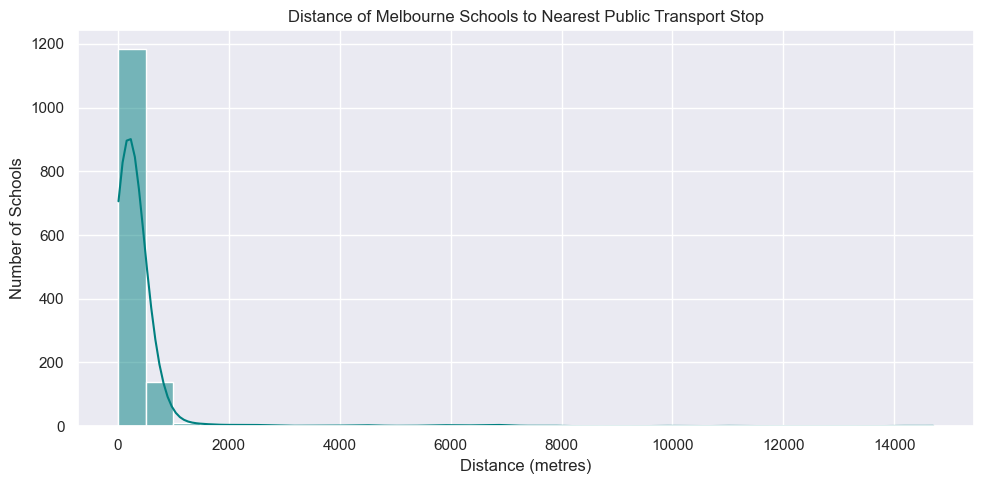

In [67]:
# Reproject to metric CRS for distance calculation
schools_df = schools_gdf_clean.to_crs(epsg=3857).copy()
transport_df = transport_stops.to_crs(epsg=3857).copy()

# Extract coordinates
school_coords = np.array(list(zip(schools_df.geometry.x, schools_df.geometry.y)))
transport_coords = np.array(list(zip(transport_df.geometry.x, transport_df.geometry.y)))

# Find nearest stop using KDTree
tree = cKDTree(transport_coords)
distances, indices = tree.query(school_coords, k=1)

# Add distances to dataframe
schools_df['Nearest_Station_Distance_m'] = distances

# Show first 5 schools with distances
print(schools_df[['School_Name', 'School_Type', 'Nearest_Station_Distance_m']].head())

# Plot histogram of distances
plt.figure(figsize=(10, 5))
sns.histplot(schools_df['Nearest_Station_Distance_m'], bins=30, kde=True, color='teal')
plt.title("Distance of Melbourne Schools to Nearest Public Transport Stop")
plt.xlabel("Distance (metres)")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()



### Distribution of Facilities by Type  

This section checks that a **Type column** exists in the dataset (using `School_Type` if available, or defaulting to "School"). It then counts how many facilities fall into each type category and visualises the results with a **bar chart**.  

By displaying the number of facilities per type, this step provides a clear overview of the dataset’s composition — for example, how many primary schools, secondary schools, or combined facilities are included. This helps new users quickly understand the balance of different educational facilities being analysed.  


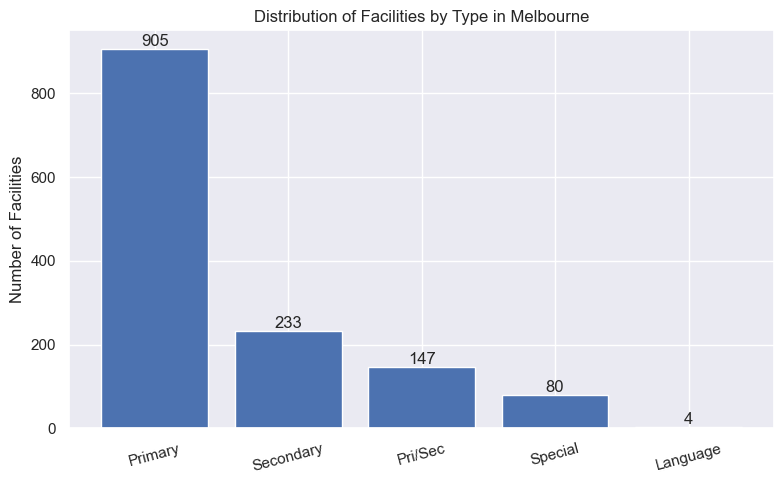

In [70]:
# Use existing map_data or copy from schools_gdf_clean
if 'map_data' not in globals():
    map_data = schools_gdf_clean.copy()

# Ensure 'Type' column exists
if 'Type' not in map_data.columns:
    if 'School_Type' in map_data.columns:
        map_data['Type'] = map_data['School_Type'].astype(str)
    else:
        map_data['Type'] = 'School'

# Count facilities by type
type_counts = map_data['Type'].value_counts(dropna=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(type_counts.index.astype(str), type_counts.values)

plt.title("Distribution of Facilities by Type in Melbourne")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=15)

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        str(int(yval)),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()



### Heatmap of Educational Facilities in Melbourne  

This section prepares geographic data for mapping. It ensures that the dataset is in the correct **WGS84 coordinate system (EPSG:4326)** and that latitude and longitude values are available for each facility. After cleaning the coordinate data, the code creates an **interactive Folium map** centered on Melbourne.  

Using the cleaned school coordinates, a **heatmap layer** is added to show areas with higher concentrations of educational facilities. Brighter regions on the map indicate suburbs where schools are clustered closely together, while darker areas highlight regions with fewer facilities. This gives users an intuitive, city-wide view of how schools are spatially distributed across Melbourne.  


In [74]:
# Ensure GeoDataFrame and convert to WGS84 if needed
if isinstance(map_data, gpd.GeoDataFrame):
    gdf = map_data.copy()
   
    if gdf.crs is not None and gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)
    if 'Latitude' not in gdf.columns or 'Longitude' not in gdf.columns:
        gdf['Latitude'] = gdf.geometry.y
        gdf['Longitude'] = gdf.geometry.x
else:
    gdf = map_data.copy()

print("Unique facility types:", gdf.columns[gdf.dtypes == 'object'])

# Clean coordinate points
pts = gdf[['Latitude', 'Longitude']].dropna()
pts = pts[(np.isfinite(pts['Latitude'])) & (np.isfinite(pts['Longitude']))]

# Create base map
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Prepare heatmap data
heatmap_points = pts[['Latitude', 'Longitude']].values.tolist()
print(f"Number of points in heatmap: {len(heatmap_points)}")

# Add heatmap layer
HeatMap(
    data=heatmap_points,
    radius=12,
    blur=15,
    max_zoom=13
).add_to(m)

m



Unique facility types: Index(['Education_Sector', 'School_Name', 'School_Type', 'School_Status',
       'Address_Town', 'LGA_Name', 'nearest_stop_name', 'Type'],
      dtype='object')
Number of points in heatmap: 1369


### School Accessibility by Type  

This section compares how far different types of schools are from their nearest public transport stop. It first extracts the relevant columns and renames the distance field for clarity. A **boxplot** is then generated to show the spread of distances across school types.  

Each boxplot illustrates the range, quartiles, and outliers for a given school type, while the **median distance** is added as a label above each box for quick reference. This makes it easy to see whether certain school types (e.g., primary, secondary, combined) tend to be located closer to or farther from public transport, helping to identify potential equity gaps in accessibility.  


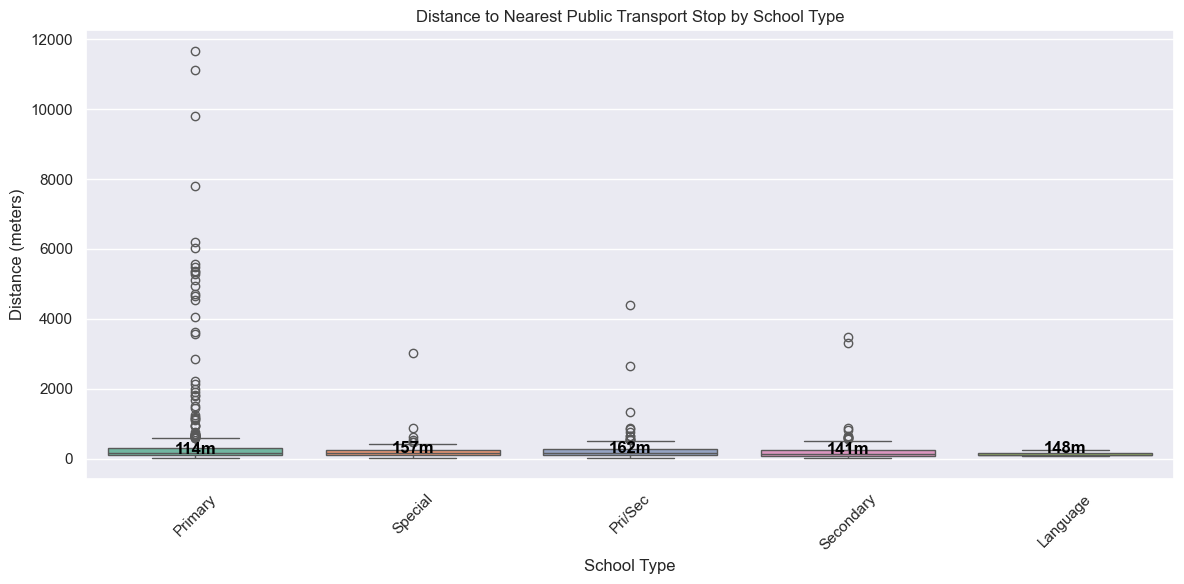

In [77]:
# Check if distance column exists
if 'nearest_stop_distance_m' in schools_gdf_clean.columns:

    facilities = schools_gdf_clean[['School_Name', 'School_Type', 'nearest_stop_distance_m']].copy()
    facilities.rename(columns={'nearest_stop_distance_m': 'DistanceToTransport'}, inplace=True)

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='School_Type',
        y='DistanceToTransport',
        hue='School_Type',   # <- explicit hue
        data=facilities,
        palette="Set2",
        legend=False         # <- suppress legend
    )

    plt.title('Distance to Nearest Public Transport Stop by School Type')
    plt.xlabel('School Type')
    plt.ylabel('Distance (meters)')
    plt.xticks(rotation=45)

    # Add median labels
    medians = facilities.groupby('School_Type')['DistanceToTransport'].median()
    for i, median in enumerate(medians):
        ax.text(i, median + 5, f'{median:.0f}m', ha='center', color='black', weight='bold')

    plt.tight_layout()
    plt.show()
else:
    print(" Column 'nearest_stop_distance_m' not found. Make sure to compute distances first.")



### Clustering Schools by Accessibility  

This section uses **KMeans clustering** to group schools based on their distance to the nearest public transport stop. After cleaning and preparing the distance data, schools are divided into three clusters that represent different levels of accessibility.  

A scatter plot is then generated, colouring each school by its assigned cluster. This makes it easier to see patterns, such as groups of schools that are very close to transport, moderately accessible, or much farther away. Clustering provides an unsupervised way of identifying distinct accessibility categories across all schools in the dataset.  


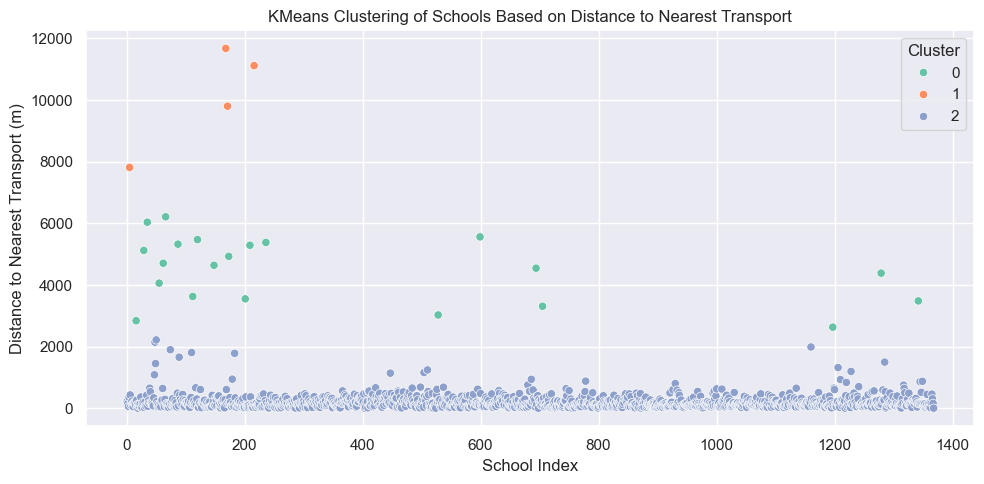

In [80]:
# === File path (relative, no hardcoding) ===
output_csv_path = Path("school_stop_all_records.csv")

# Load school-stop dataset
df = pd.read_csv(output_csv_path)

# Clean and convert distance column
df['nearest_stop_distance_m'] = pd.to_numeric(df['nearest_stop_distance_m'], errors='coerce')
df.dropna(subset=['nearest_stop_distance_m'], inplace=True)

# Apply KMeans clustering
distance_data = df[['nearest_stop_distance_m']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(distance_data)

# Scatter plot with clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=range(len(df)),
    y='nearest_stop_distance_m',
    hue='Cluster',
    data=df,
    palette='Set2'
)
plt.title('KMeans Clustering of Schools Based on Distance to Nearest Transport')
plt.xlabel('School Index')
plt.ylabel('Distance to Nearest Transport (m)')
plt.tight_layout()
plt.show()


### Trend Analysis Using Linear Regression  

This section applies a **linear regression model** to explore whether there is a trend in the distances of schools to their nearest public transport stop. The school dataset is indexed, and the model attempts to predict transport distances based on this order.  

The model’s performance is evaluated using **Mean Squared Error (MSE)** and **R² (coefficient of determination)**, which are shown in the plot title. A scatter plot displays the actual school distances, while a red line represents the regression trend.  

This analysis provides a simple way to check whether distances are randomly distributed or whether there may be an underlying trend (for example, certain groups of schools consistently being farther from transport).  


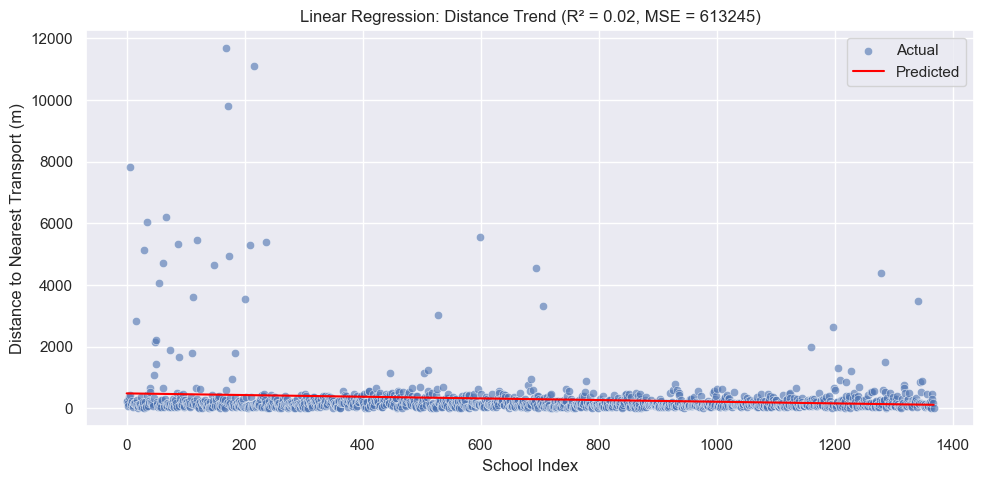

In [82]:
# Prepare data for regression
df['Index'] = range(len(df))
X = df[['Index']]
y = df['nearest_stop_distance_m']

# Train linear regression model
reg = LinearRegression()
reg.fit(X, y)
df['Predicted_Distance'] = reg.predict(X)

# Evaluate model performance
mse = mean_squared_error(y, df['Predicted_Distance'])
r2 = r2_score(y, df['Predicted_Distance'])

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Index', y='nearest_stop_distance_m', data=df, label='Actual', alpha=0.6)
sns.lineplot(x='Index', y='Predicted_Distance', data=df, label='Predicted', color='red')
plt.title(f'Linear Regression: Distance Trend (R² = {r2:.2f}, MSE = {mse:.0f})')
plt.xlabel('School Index')
plt.ylabel('Distance to Nearest Transport (m)')
plt.tight_layout()
plt.show()


### Accessibility by Education Sector and Local Government Area (LGA)  

This section compares school accessibility in two ways:  

- **Education Sector**: A statistical summary is produced for each sector (e.g., government, Catholic, independent), showing the distribution of distances from schools to their nearest transport stop. A boxplot visualises these results, making it easier to see which sectors generally have better or worse access.  

- **Local Government Area (LGA)**: For each LGA, the number of schools, average distance, median distance, and maximum distance are calculated. The results are sorted by median distance to highlight the LGAs where schools are farthest from transport. A bar chart of median distances provides a quick comparison across the top LGAs.  

Together, these comparisons reveal whether accessibility challenges are more closely linked to the **type of school system** (sector) or the **geographic location** (LGA).  


 Distance to Transport by Education Sector (meters):

                  count        mean         std        min         25%  \
Education_Sector                                                         
Catholic          316.0  183.168677  145.674279  10.230565   86.789453   
Government        892.0  347.989624  946.209273   6.821766   87.407037   
Independent       161.0  297.356611  526.753417  15.179205  103.054926   

                         50%         75%           max  
Education_Sector                                        
Catholic          136.887443  229.791137    936.639981  
Government        166.201984  287.685061  11672.807898  
Independent       155.021340  267.702812   4387.655414   



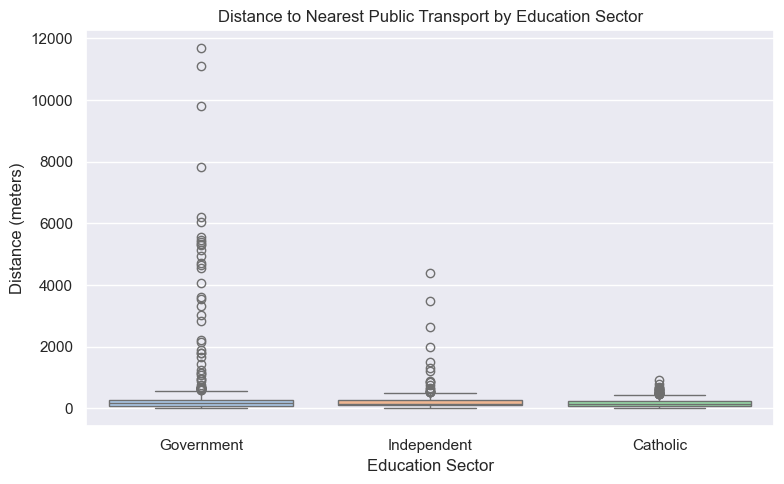

 LGA Accessibility Stats (meters):

                          count         mean       median           max
LGA_Name                                                               
Unincorporated Vic            1  9800.145349  9800.145349   9800.145349
Murrindindi (S)               4  3500.301482  1083.487478  11672.807898
Mitchell (S)                  5  1520.382716   456.549027   4709.069137
Macedon Ranges (S)           12  1370.533444   356.122973   6038.192019
Yarra Ranges (S)             63   617.285102   284.923717   4931.896181
Nillumbik (S)                27  1320.794901   267.254901   7814.978677
Mornington Peninsula (S)     49   604.906716   249.977374   4547.142090
Greater Geelong (C)          16   338.165759   224.386984    950.157806
Moorabool (S)                 8  2184.733346   206.829875  11114.245705
Maroondah (C)                33   221.119313   196.384394    553.068497
Monash (C)                   56   225.463652   193.410278    634.233220
Queenscliffe (B)            

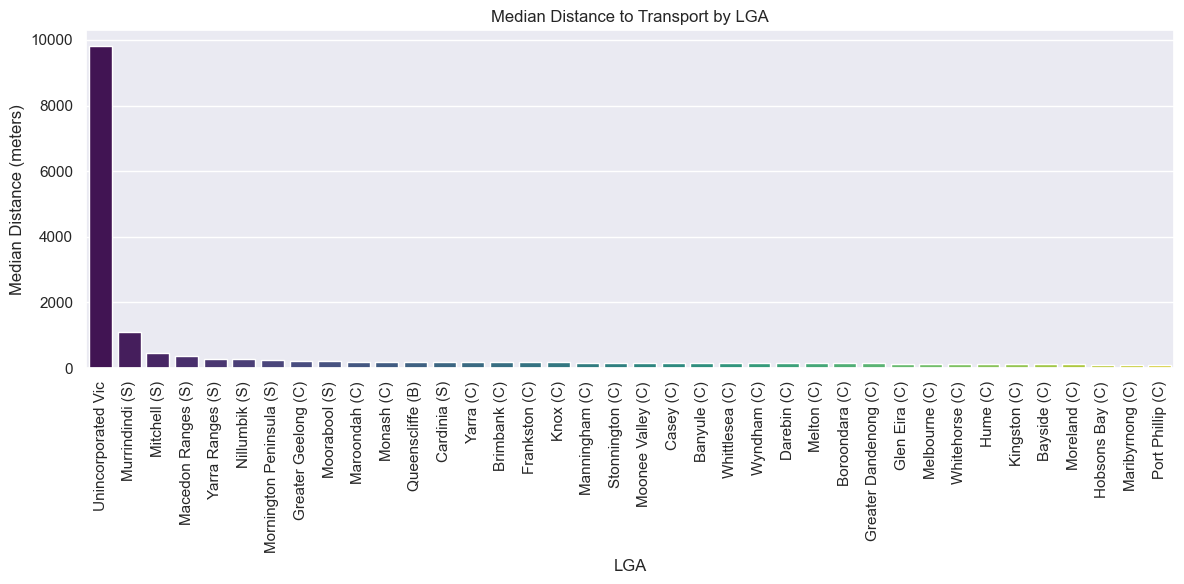

In [86]:
# Check and analyse by Education Sector
if "Education_Sector" in schools_gdf_clean.columns:
    sector_stats = schools_gdf_clean.groupby("Education_Sector")["nearest_stop_distance_m"].describe()
    print(" Distance to Transport by Education Sector (meters):\n")
    print(sector_stats, "\n")

    # Boxplot of distance by education sector
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        x="Education_Sector",
        y="nearest_stop_distance_m",
        hue="Education_Sector",   # <- add hue
        data=schools_gdf_clean,
        palette="pastel",
        legend=False              # <- suppress legend
    )
    plt.title("Distance to Nearest Public Transport by Education Sector")
    plt.xlabel("Education Sector")
    plt.ylabel("Distance (meters)")
    plt.tight_layout()
    plt.show()
else:
    print(" Column 'Education_Sector' not found in dataframe.")

# Check and analyse by LGA
if "LGA_Name" in schools_gdf_clean.columns:
    lga_stats = (
        schools_gdf_clean.groupby("LGA_Name")["nearest_stop_distance_m"]
        .agg(["count", "mean", "median", "max"])
        .sort_values("median", ascending=False)
    )
    print(" LGA Accessibility Stats (meters):\n")
    print(lga_stats.head(15), "\n")  

    # Barplot of median distances by LGA
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=lga_stats.index,
        y=lga_stats["median"],
        hue=lga_stats.index,      # <- add hue
        palette="viridis",
        legend=False              # <- suppress legend
    )
    plt.xticks(rotation=90)
    plt.title("Median Distance to Transport by LGA")
    plt.ylabel("Median Distance (meters)")
    plt.xlabel("LGA")
    plt.tight_layout()
    plt.show()
else:
    print(" Column 'LGA_Name' not found in dataframe.")



### **Analysis of School Accessibility by Sector and Type**

This code evaluates school accessibility in two ways:

- **Education Sector Thresholds**: It calculates the percentage of schools in each sector located within 500 m and 1000 m of a public transport stop. This provides a quick benchmark of how well sectors meet common accessibility standards.  
- **School Type Comparison**: It computes summary statistics (count, mean, median, max) for different school types and displays them in a boxplot. This helps highlight which types of schools have better access to transport and where gaps in equity exist.  


In [88]:
# Define distance thresholds
thresholds = [500, 1000]

# Calculate % of schools within each threshold by sector
for t in thresholds:
    counts = (
        schools_gdf_clean
        .groupby("Education_Sector")["nearest_stop_distance_m"]
        .apply(lambda x: (x <= t).mean() * 100)
    )
    print(f" % of Schools within {t}m of Transport:")
    print(counts.round(1), "\n")



 % of Schools within 500m of Transport:
Education_Sector
Catholic       94.6
Government     92.7
Independent    87.6
Name: nearest_stop_distance_m, dtype: float64 

 % of Schools within 1000m of Transport:
Education_Sector
Catholic       100.0
Government      96.3
Independent     95.7
Name: nearest_stop_distance_m, dtype: float64 



 Distance to Transport by School Type (meters):

             count        mean      median           max
School_Type                                             
Primary        905  344.326028  162.390994  11672.807898
Pri/Sec        147  261.386756  156.983907   4387.655414
Special         80  217.054966  148.277593   3031.601574
Secondary      233  206.835211  140.734732   3486.814075
Language         4  141.637594  114.063075    253.429573 



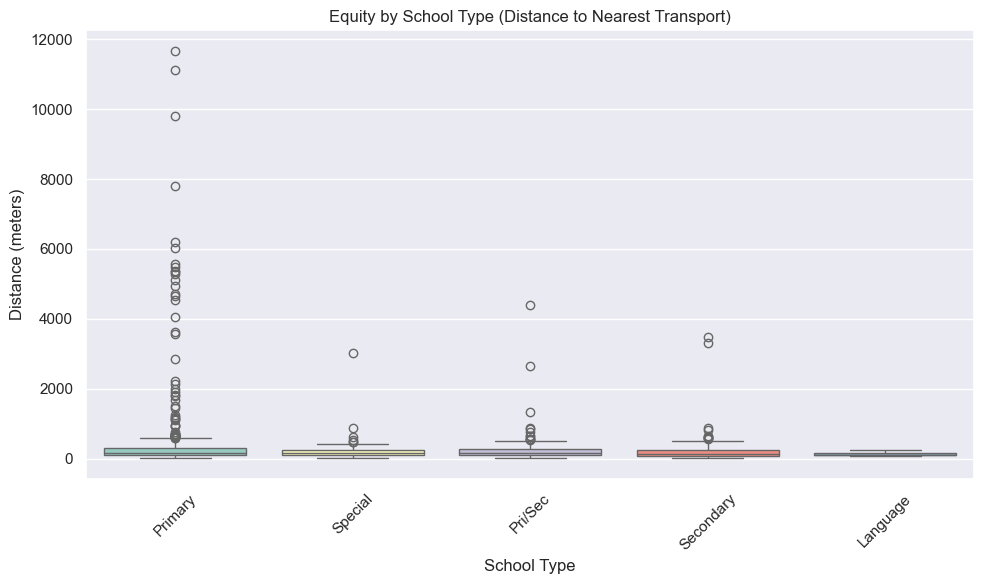

In [89]:
# Check and analyse by School Type
if "School_Type" in schools_gdf_clean.columns:
    type_stats = (
        schools_gdf_clean.groupby("School_Type")["nearest_stop_distance_m"]
        .agg(["count", "mean", "median", "max"])
        .sort_values("median", ascending=False)
    )
    print(" Distance to Transport by School Type (meters):\n")
    print(type_stats, "\n")

    # Boxplot of distances by school type
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="School_Type",
        y="nearest_stop_distance_m",
        hue="School_Type",   # <- added hue
        data=schools_gdf_clean,
        palette="Set3",
        legend=False         # <- suppress legend
    )
    plt.title("Equity by School Type (Distance to Nearest Transport)")
    plt.xlabel("School Type")
    plt.ylabel("Distance (meters)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(" Column 'School_Type' not found in dataframe.")



## ***Top 10 Farthest school from public transport***

In [92]:
# Select top 10 schools farthest from transport
top10 = schools_gdf_clean.sort_values("nearest_stop_distance_m", ascending=False).head(10)

print(" Top 10 Schools Farthest from Public Transport:\n")
print(top10[["School_Name", "Education_Sector", "School_Type", "LGA_Name", "nearest_stop_distance_m"]])


 Top 10 Schools Farthest from Public Transport:

                                  School_Name Education_Sector School_Type  \
168                   Toolangi Primary School       Government     Primary   
216              Balliang East Primary School       Government     Primary   
171               Perseverance Primary School       Government     Primary   
5                   St Andrews Primary School       Government     Primary   
66             Christmas Hills Primary School       Government     Primary   
35              Darraweit Guim Primary School       Government     Primary   
599  Toolern Vale and District Primary School       Government     Primary   
120         Beaconsfield Upper Primary School       Government     Primary   
236                 Strathewen Primary School       Government     Primary   
87               Arthurs Creek Primary School       Government     Primary   

               LGA_Name  nearest_stop_distance_m  
168     Murrindindi (S)             11672

## ***Top 10 Suburbs by Median Distance to transport***

In [96]:
# Check and analyse by suburb (Address_Town)
if "Address_Town" in schools_gdf_clean.columns:
    suburb_stats = (
        schools_gdf_clean.groupby("Address_Town")["nearest_stop_distance_m"]
        .agg(["count", "mean", "median"])
        .sort_values("median", ascending=False)
    )
    print(" Top 10 Suburbs by Median Distance to Transport:\n")
    print(suburb_stats.head(10), "\n")


 Top 10 Suburbs by Median Distance to Transport:

                    count          mean        median
Address_Town                                         
Toolangi                1  11672.807898  11672.807898
Balliang East           1  11114.245705  11114.245705
French Island           1   9800.145349   9800.145349
St Andrews              1   7814.978677   7814.978677
Christmas Hills         1   6213.668169   6213.668169
Darraweit Guim          1   6038.192019   6038.192019
Toolern Vale            1   5562.728750   5562.728750
BEACONSFIELD UPPER      1   5474.300386   5474.300386
Strathewen              1   5383.034039   5383.034039
Arthurs Creek           1   5327.418029   5327.418029 



### School Accessibility by Distance Thresholds

This code measures overall accessibility by calculating the percentage of schools located within **250 m, 500 m, and 1000 m** of the nearest public transport stop.  
The results are displayed in a simple bar chart, making it easy to see how many schools fall within close walking distance and how coverage improves as the distance threshold increases.  


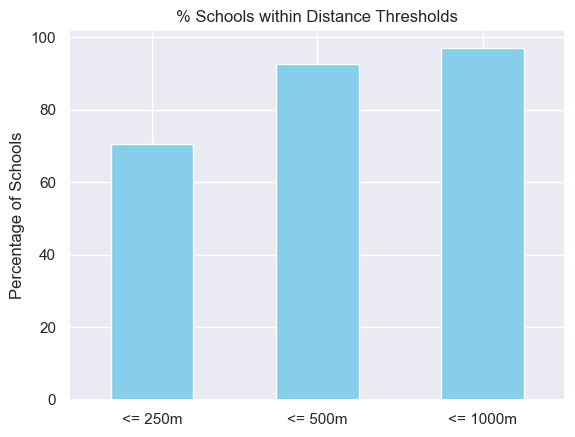

In [100]:
thresholds = [250, 500, 1000]
results = {}
for t in thresholds:
    results[f"<= {t}m"] = (schools_gdf_clean["nearest_stop_distance_m"] <= t).mean() * 100
pd.Series(results).plot(kind="bar", color="skyblue", rot=0, title="% Schools within Distance Thresholds")
plt.ylabel("Percentage of Schools")
plt.show()


### Suburb Ranking by Accessibility

This code ranks suburbs based on the **median distance of schools to the nearest public transport stop**.  
- The **Top 10 best-connected suburbs** are displayed first, showing areas where schools enjoy the shortest travel distances to transport.  
- The **Bottom 10 worst-connected suburbs** are also listed, highlighting areas where schools face greater accessibility challenges.  

This ranking provides a clear way to identify geographic inequalities in school transport access across Melbourne suburbs.  


In [103]:
# Rank suburbs by median distance
suburb_ranking = (
    schools_gdf_clean.groupby("Address_Town")["nearest_stop_distance_m"]
    .median()
    .sort_values()
    .reset_index()
)
suburb_ranking["Rank"] = range(1, len(suburb_ranking)+1)

print(" Top 10 Best-Connected Suburbs:\n")
print(suburb_ranking.head(10))

print("\n Bottom 10 Worst-Connected Suburbs:\n")
print(suburb_ranking.tail(10))


 Top 10 Best-Connected Suburbs:

        Address_Town  nearest_stop_distance_m  Rank
0       KEILOR NORTH                10.298178     1
1        Maribyrnong                12.971118     2
2          MT RIDLEY                15.927768     3
3     Essendon North                18.185327     4
4           Kallista                18.440275     5
5              Clyde                24.199940     6
6           Seabrook                25.204868     7
7  Pascoe Vale South                26.974484     8
8      CLAYTON SOUTH                34.744241     9
9          ASHBURTON                35.253986    10

 Bottom 10 Worst-Connected Suburbs:

           Address_Town  nearest_stop_distance_m  Rank
655       Arthurs Creek              5327.418029   656
656          Strathewen              5383.034039   657
657  BEACONSFIELD UPPER              5474.300386   658
658        Toolern Vale              5562.728750   659
659      Darraweit Guim              6038.192019   660
660     Christmas Hills    

## 5.0 Key Findings, Impact, and Future Recommendations

### Key Findings
- **School–Transport Accessibility**: Analysis showed that while many schools in metropolitan Melbourne are located close to public transport stops, a significant number—particularly combined primary/secondary institutions—are situated further away. This highlights unequal accessibility among educational facilities.  
- **Education Sector Disparities**: Private and Catholic schools generally exhibited closer proximity to transport hubs compared to government schools, pointing to possible equity gaps.  
- **Local Government Variation**: Certain LGAs demonstrated better integration of schools with public transport, whereas others had larger accessibility gaps, suggesting uneven policy implementation or urban planning differences.  
- **Statistical & Visual Evidence**: Boxplots, heatmaps, and regression trends consistently revealed measurable differences across school types and regions, supporting the need for targeted planning interventions.

### Impact
- **Urban Planning**: Findings provide clear evidence for policymakers and urban planners to prioritise transport infrastructure near schools with poor access.  
- **Educational Equity**: Unequal accessibility may indirectly affect student attendance, punctuality, and overall academic performance, especially for families reliant on public transport.  
- **Community Benefits**: Improved school–transport connectivity not only assists students but also strengthens broader community mobility, reducing reliance on private vehicles and lowering congestion.  
- **Policy Influence**: Results can contribute to future infrastructure investment decisions by highlighting areas with the greatest accessibility gaps.

### Future Recommendations
1. **Targeted Transport Infrastructure**  
   - Prioritise adding or relocating bus, tram, or train stops closer to schools identified as having the largest accessibility gaps.  

2. **Equity-Focused Policy Development**  
   - Ensure government schools are not disadvantaged compared to private and Catholic institutions by incorporating accessibility measures into funding and zoning policies.  

3. **Cross-Sector Collaboration**  
   - Encourage collaboration between the Department of Education, local councils, and Public Transport Victoria to align school expansion plans with transport development.  

4. **Further Research**  
   - Extend the analysis beyond Melbourne to regional Victoria to identify broader accessibility disparities.  
   - Incorporate other datasets (e.g., socioeconomic indicators, student enrolment sizes, disability access) to gain a more holistic view of educational equity.  

5. **Monitoring and Evaluation**  
   - Develop a longitudinal monitoring framework to track accessibility improvements over time and evaluate the effectiveness of new transport investments.  

In summary, this study highlights how spatial inequalities in transport access directly intersect with educational equity. By addressing these disparities through targeted policy, infrastructure planning, and ongoing monitoring, Victoria can move towards a fairer and more accessible education system for all students.
